## Importations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

from sklearn.impute import SimpleImputer

from xgboost import DMatrix, train

## Data Loading

In [2]:
# load data
DIR = "data"
# CSV_FILE = "mafaulda_48khz_500ms_25ms_40-mfcc.csv"    # best until now
# CSV_FILE = "mafaulda_16khz_500ms_20ms_40-mfcc.csv"
# CSV_FILE = "new_mafaulda_24khz_500ms_20ms_40-mfcc.csv"
# CSV_FILE = "mafaulda_subclasses_16khz_500ms_20ms_40-mfcc.csv"
CSV_FILE = "new_mafaulda_subclasses_24khz_500ms_20ms_40-mfcc.csv"
df = pd.read_csv(DIR + "/" + CSV_FILE)

# adding source column to the dataframe
df["source"] = "original"

# show dataframe info
df.info()

# show dataframe head
df.head()

# print number of samples per class
df["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19510 entries, 0 to 19509
Columns: 147 entries, mean to source
dtypes: float64(143), int64(1), object(3)
memory usage: 21.9+ MB


vertical_misalignment_051     510
vertical_misalignment_190     500
vertical_misalignment_127     500
underhang_ball_00             500
vertical_misalignment_178     500
vertical_misalignment_140     500
horizontal_misalignment_05    500
vertical_misalignment_063     500
underhang_ball_20             490
underhang_cage_00             490
underhang_outer_20            490
underhang_ball_06             490
underhang_cage_20             490
overhang_outer_20             490
overhang_outer_06             490
overhang_outer_00             490
overhang_cage_20              490
overhang_cage_06              490
overhang_cage_00              490
normal                        490
underhang_outer_00            490
underhang_outer_06            490
overhang_ball_00              490
horizontal_misalignment_10    490
horizontal_misalignment_15    490
horizontal_misalignment_20    490
imbalance_20                  490
imbalance_06                  490
underhang_cage_06             480
imbalance_10  

In [3]:
# count the number of NaN values in each column
total_nan = df.isna().sum().sum()

# count the number of rows with at least one NaN value
rows_nan = df.isna().any(axis=1).sum()

# count the number of columns with at least one NaN value
columns_nan = df.isna().any().sum()

# create a copy of dataframe without columns with at least NaN
df_without_nan = df.dropna(axis=1)

print("NaN values in DataFrame:", total_nan)
print("Rows with at least one NaN value:", rows_nan)
print("Columns with at least one NaN value:", columns_nan)

NaN values in DataFrame: 0
Rows with at least one NaN value: 0
Columns with at least one NaN value: 0


In [4]:
# extract the features and the class
features = df_without_nan.drop(columns=["filename", "label", "class", "source"])
class_column = df_without_nan["class"]

# encode class column if necessary
label_encoder = preprocessing.LabelEncoder()
class_column_encoded = label_encoder.fit_transform(class_column)

# set X and y values
X = features.values
y = class_column_encoded.copy()

In [5]:
# apply ADASYN (oversampling minority class) to the dataset
X_resampled, y_resampled = ADASYN(sampling_strategy="minority", random_state=42).fit_resample(X, y)

# create a new dataframe with the new samples
new_df = pd.DataFrame(X_resampled, columns=features.columns)
new_df["class"] = label_encoder.inverse_transform(y_resampled)
new_df["source"] = "generated"

# add label column to the dataframe of new samples
class_names_lst = list(df["label"].unique())
for idx, class_name in enumerate(class_names_lst):
    new_df.loc[new_df["class"] == idx, "label"] = class_name

# add filename column to the new dataframe
original_filenames = df["filename"].values
new_filenames = [f"generated_{i}.wav" for i in range(len(original_filenames), len(original_filenames) + len(new_df))]
new_df["filename"] = new_filenames

# print the amount of new samples generated per class
new_df["label"].value_counts()

overhang_ball_35              537
vertical_misalignment_051     510
vertical_misalignment_127     500
underhang_ball_00             500
vertical_misalignment_190     500
vertical_misalignment_178     500
vertical_misalignment_140     500
horizontal_misalignment_05    500
vertical_misalignment_063     500
underhang_outer_00            490
underhang_outer_06            490
overhang_cage_00              490
underhang_cage_00             490
underhang_ball_20             490
underhang_ball_06             490
underhang_outer_20            490
overhang_outer_20             490
overhang_outer_06             490
overhang_outer_00             490
overhang_cage_20              490
overhang_cage_06              490
underhang_cage_20             490
normal                        490
imbalance_20                  490
horizontal_misalignment_10    490
horizontal_misalignment_20    490
imbalance_06                  490
horizontal_misalignment_15    490
overhang_ball_00              490
imbalance_10  

In [6]:
# concatenate the original dataframe with the new dataframe
df_resampled = pd.concat([df, new_df], ignore_index=True)

# show dataframe info
df_resampled.info()

# print number of samples per class
df_resampled["label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39357 entries, 0 to 39356
Columns: 147 entries, mean to source
dtypes: float64(143), int64(1), object(3)
memory usage: 44.1+ MB


vertical_misalignment_051     1020
vertical_misalignment_190     1000
vertical_misalignment_127     1000
underhang_ball_00             1000
vertical_misalignment_178     1000
vertical_misalignment_140     1000
horizontal_misalignment_05    1000
vertical_misalignment_063     1000
underhang_ball_20              980
underhang_cage_00              980
underhang_outer_20             980
underhang_ball_06              980
underhang_cage_20              980
overhang_outer_20              980
overhang_outer_06              980
overhang_outer_00              980
overhang_cage_20               980
overhang_cage_06               980
overhang_cage_00               980
normal                         980
underhang_outer_00             980
underhang_outer_06             980
overhang_ball_00               980
horizontal_misalignment_10     980
horizontal_misalignment_15     980
horizontal_misalignment_20     980
imbalance_20                   980
imbalance_06                   980
underhang_cage_06   

In [7]:
FEATURES_LST    = df.columns.drop(['class', 'label', 'filename', 'source'])
labels          = list(df_resampled["label"].unique())

In [8]:
# splitting the data into training and test sets
TEST_SIZE       = 0.20
RANDOM_STATE    = 42

unique_files = df_resampled["filename"].unique()

train_files, test_files = model_selection.train_test_split(unique_files, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train_df    = df_resampled[df_resampled['filename'].isin(train_files)]
test_df     = df_resampled[df_resampled['filename'].isin(test_files)]

print(f"Train files:    {len(train_files)}  ({len(train_df) / len(df_resampled) * 100:.2f}%)")
print(f"Test files:     {len(test_files)}   ({len(test_df) / len(df_resampled) * 100:.2f}%)")
print(f"Train samples:  {len(train_df)}     ({len(train_df) / len(df_resampled) * 100:.2f}%)")
print(f"Test samples:   {len(test_df)}      ({len(test_df) / len(df_resampled) * 100:.2f}%)")

Train files:    17438  (81.17%)
Test files:     4360   (18.83%)
Train samples:  31946     (81.17%)
Test samples:   7411      (18.83%)


In [9]:
X_train = train_df[FEATURES_LST].values
y_train = train_df["class"].values

X_test  = test_df[FEATURES_LST].values
y_test  = test_df["class"].values

In [10]:
scaler = preprocessing.RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [11]:
# defining the cross-validation strategy
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [12]:
# create an imputer
my_imputer = SimpleImputer()

# impute missing values
X_train = my_imputer.fit_transform(X_train)
X_test  = my_imputer.transform(X_test)

# Convert the datasets into DMatrix
dtrain  = DMatrix(X_train, label=y_train)
dtest   = DMatrix(X_test, label=y_test)

Fold 1 accuracy: 0.9942
Fold 2 accuracy: 0.9950
Fold 3 accuracy: 0.9917
Fold 4 accuracy: 0.9919
Fold 5 accuracy: 0.9901

Mean accuracy: 0.9926 ± 0.0018


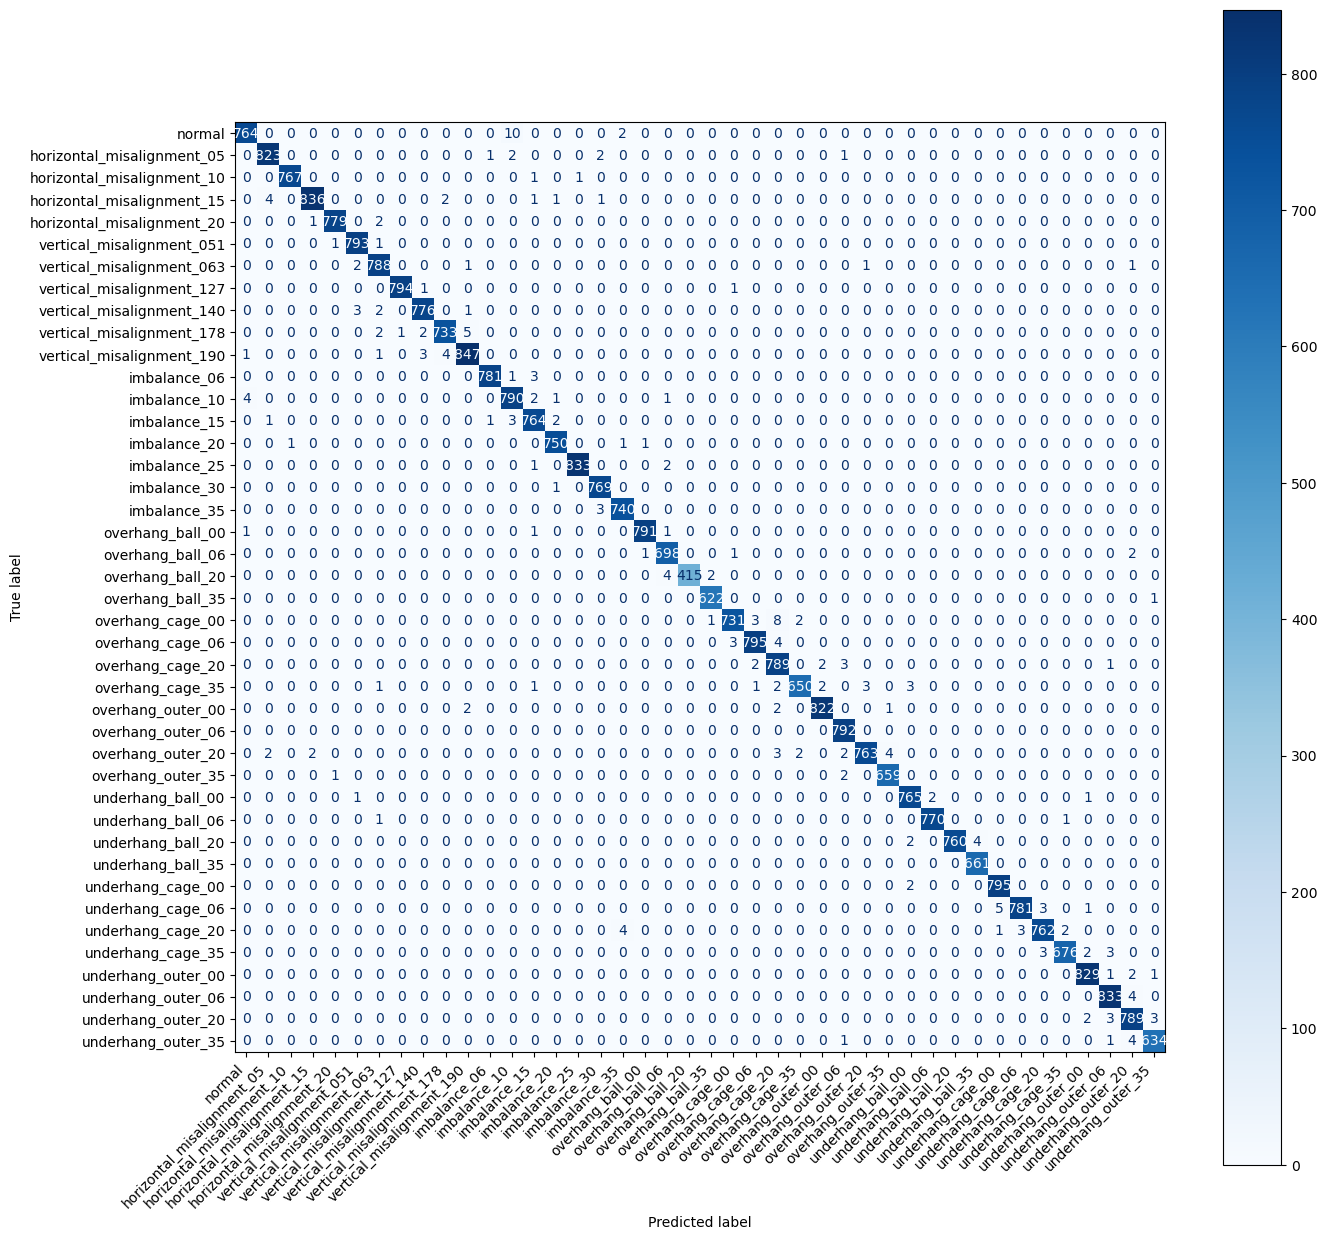

In [13]:
NUM_BOOST_ROUND = 100

# define parameters for the XGBoost model
params = {
    'max_depth':                5,
    'learning_rate':            0.1,
    'subsample':                0.7,
    'colsample_bytree':         0.8,
    'colsample_bylevel':        0.8,
    'objective':                'multi:softprob',
    'eval_metric':              'mlogloss',
    'random_state':             42,
    'tree_method':              'hist',
    'device':                   'cuda',
    'num_class':                len(np.unique(y_train))
}

# Lists to store accuracy of each fold and predictions
accuracy_list = []
y_test_all = []
y_pred_all = []

# Perform Stratified K-Fold Cross Validation
fold_number = 1
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    # Convert the datasets into DMatrix
    dtrain = DMatrix(X_train_fold, label=y_train_fold)
    dtest = DMatrix(X_test_fold, label=y_test_fold)
    
    # Train the model
    evals = [(dtest, 'eval'), (dtrain, 'train')]
    bst = train(params, dtrain, num_boost_round=NUM_BOOST_ROUND, evals=evals, early_stopping_rounds=10, verbose_eval=False)
    
    # Make predictions
    y_pred_proba = bst.predict(dtest)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test_fold, y_pred)
    accuracy_list.append(accuracy)
    
    # Store predictions for confusion matrix
    y_test_all.extend(y_test_fold)
    y_pred_all.extend(y_pred)
    
    print(f'Fold {fold_number} accuracy: {accuracy:.4f}')
    
    fold_number += 1

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"\nMean accuracy: {mean_accuracy:.4f} ± {np.std(accuracy_list):.4f}")

# Ploting Confusion Matrix
cm = metrics.confusion_matrix(y_test_all, y_pred_all)
class_names = list(df_resampled["label"].unique())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=45, ha='right')
plt.show()

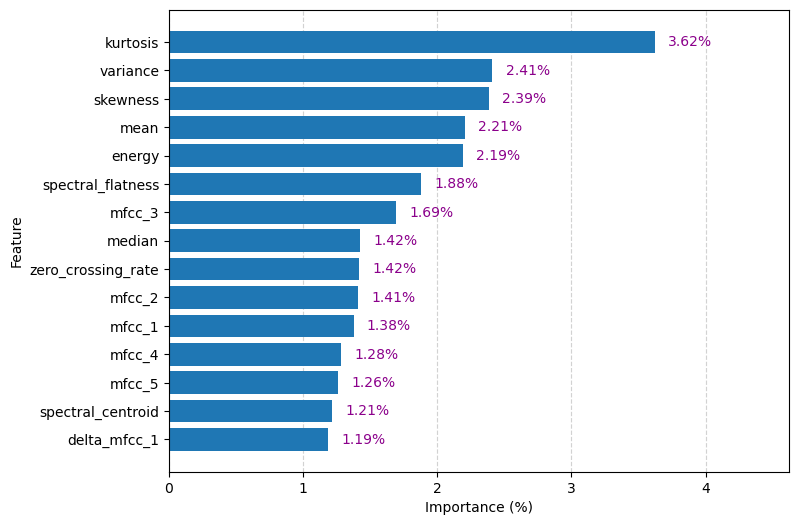

In [14]:
# Get the feature importances from the last trained model
feature_importances = bst.get_score(importance_type='weight')

# Map the feature importances to the original feature names
importance_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
importance_df.index = [FEATURES_LST[int(feat[1:])] for feat in importance_df.index]  # Convert 'f0', 'f1', ... to feature names
importance_df.index.name = 'feature'
importance_df.reset_index(inplace=True)

# Normalize importances to sum up to 1 and convert to percentage
importance_df['importance'] /= importance_df['importance'].sum()
importance_df['importance_percent'] = importance_df['importance'] * 100

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Select the top 15 features
top_features = importance_df.head(15)

# Plot the feature importances as percentages
plt.figure(figsize=(8, 6))
bars = plt.barh(top_features['feature'], top_features['importance_percent'], zorder=2)
plt.grid(linestyle='--', axis='x', linewidth=0.85, color='gray', alpha=0.35, zorder=0)
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Add the importance values to the right of each bar
for bar, value in zip(bars, top_features['importance_percent']):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{value:.2f}%', va='center', color='darkmagenta')

# Set the xlim to ensure the text stays within the plot
plt.xlim(0, top_features['importance_percent'].max() + 1)  # Add minimal padding to the xlim

plt.show()

In [15]:
def train_model(X_train, y_train, n_estimators=10, verbose_eval=False):
    skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # define parameters for the XGBoost model
    params = {
        'max_depth':                5,
        'learning_rate':            0.1,
        'subsample':                0.7,
        'colsample_bytree':         0.8,
        'colsample_bylevel':        0.8,
        'objective':                'multi:softprob',
        'eval_metric':              'mlogloss',
        'random_state':             42,
        'tree_method':              'hist',
        'device':                   'cuda',
        'num_class':                len(np.unique(y_train))
    }

    # Lists to store accuracy of each fold and predictions
    accuracy_list = []
    y_test_all = []
    y_pred_all = []

    # Perform Stratified K-Fold Cross Validation
    fold_number = 1
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # Convert the datasets into DMatrix
        dtrain = DMatrix(X_train_fold, label=y_train_fold)
        dtest = DMatrix(X_test_fold, label=y_test_fold)
        
        # Train the model
        evals = [(dtest, 'eval'), (dtrain, 'train')]
        bst = train(params, dtrain, num_boost_round=n_estimators, evals=evals, verbose_eval=False)
        
        # Make predictions
        y_pred_proba = bst.predict(dtest)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Calculate accuracy
        accuracy = metrics.accuracy_score(y_test_fold, y_pred)
        accuracy_list.append(accuracy)
        
        # Store predictions for confusion matrix
        y_test_all.extend(y_test_fold)
        y_pred_all.extend(y_pred)
        
        fold_number += 1
    
    return accuracy_list, y_test_all, y_pred_all

In [16]:
# Train model with different numbers of estimators
full_accuracy_list  = []
full_y_test_all     = []
full_y_pred_all     = []

for n_estimators in range(5, 200+5, 5):
    accuracy_list, y_test_all, y_pred_all = train_model(X_train, y_train, n_estimators, verbose_eval=True)
    
    print(f"Number of estimators: {n_estimators:3} ...")
    
    full_accuracy_list.append(accuracy_list)
    full_y_test_all.extend(y_test_all)
    full_y_pred_all.extend(y_pred_all)

full_mean_acc   = np.mean(full_accuracy_list, axis=1)
full_std_acc    = np.std(full_accuracy_list, axis=1)

Number of estimators:   5 ...
Number of estimators:  10 ...
Number of estimators:  15 ...
Number of estimators:  20 ...
Number of estimators:  25 ...
Number of estimators:  30 ...
Number of estimators:  35 ...
Number of estimators:  40 ...
Number of estimators:  45 ...
Number of estimators:  50 ...
Number of estimators:  55 ...
Number of estimators:  60 ...
Number of estimators:  65 ...
Number of estimators:  70 ...
Number of estimators:  75 ...
Number of estimators:  80 ...
Number of estimators:  85 ...
Number of estimators:  90 ...
Number of estimators:  95 ...
Number of estimators: 100 ...
Number of estimators: 105 ...
Number of estimators: 110 ...
Number of estimators: 115 ...
Number of estimators: 120 ...
Number of estimators: 125 ...
Number of estimators: 130 ...
Number of estimators: 135 ...
Number of estimators: 140 ...
Number of estimators: 145 ...
Number of estimators: 150 ...
Number of estimators: 155 ...
Number of estimators: 160 ...
Number of estimators: 165 ...
Number of 

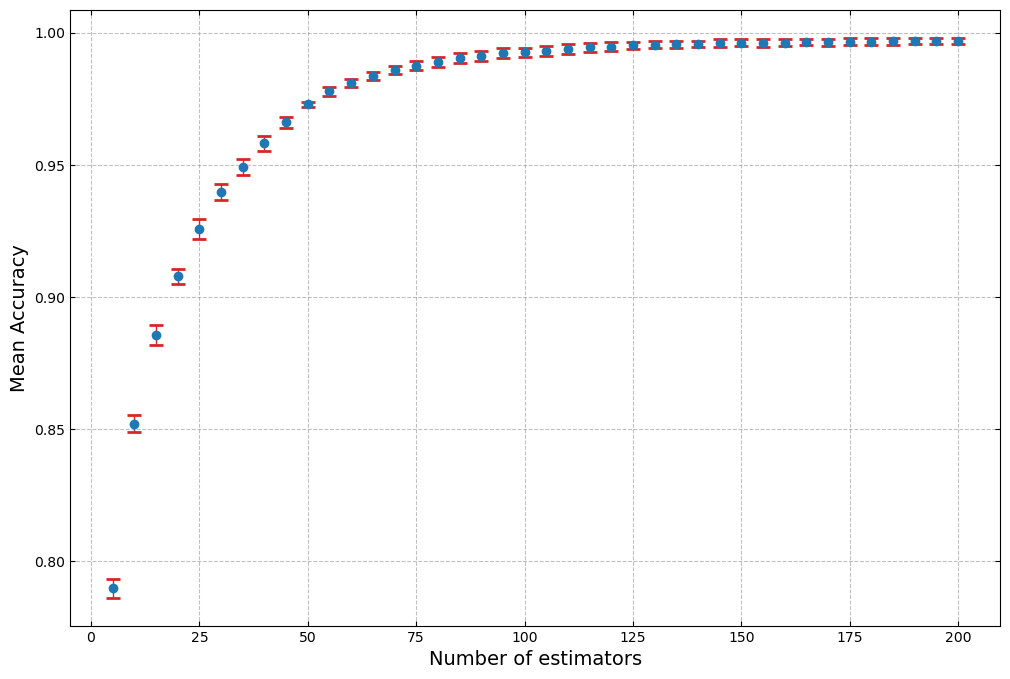

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.errorbar(range(5, 200+5, 5), full_mean_acc, yerr=full_std_acc, fmt='o', markersize=6, capsize=5, capthick=2, color="C0", ecolor="C3", elinewidth=1, linestyle='')
ax.grid(True, which='both', linestyle='--', linewidth=0.75, color='gray', alpha=0.5)
ax.xaxis.set_tick_params(direction='in', which='both', top=True, right=True)
ax.yaxis.set_tick_params(direction='in', which='both', right=True)
ax.set_xlabel('Number of estimators', fontsize=14)
ax.set_ylabel('Mean Accuracy', fontsize=14)

plt.show()